# The fast spectral method

By choosing the test function $\phi(v) = e^{-i\frac{\pi}{L} k\cdot v}$ in the weak form, we can obtain the Fourier expansion of $Q$:

$$\hat{Q}_k= \sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1} G(l,m) \hat{f}_l \hat{f}_m\,,$$

where the weight $G(l,m)$ is given by

$$
G(l,m)=\int_{\mathbb{R}^d}e^{-i\frac{\pi}{L}m \cdot g}\bigg[\int_{S^{d-1}}B_{\sigma}(\lvert g\rvert,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}{\sigma}\bigg]\,\mathrm{d}{g} \,,
$$

where $g$ needs to be truncated properly as was done for the elastic case. 

The idea of the fast algorithm is to separate the weight $G$ as $G(l,m)\approx\sum_{t=1}^T\alpha_t(l+m)\beta_t(m)$ using quadrature rules.

In [1]:
%matplotlib inline
import numpy as np
from math import pi
from scipy import special
import matplotlib.pyplot as plt
import pyfftw

import sys
sys.path.append('../src')
from fast_spec_col_3d import FastSpectralCollison3D
from direct_col_3d import DirectCol3D
from utility import get_config, RK3

## 3D case

In 3D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^2}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}\sigma=4\pi C_{\gamma}|g|^{\gamma}\bigg[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\vert l+m \vert|g|\right)-1\bigg],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho (l+m)\cdot \sigma}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-1\right],
$$

therefore,

$$ 
\hat{Q}_k=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho k\cdot \sigma}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\rho |k|\right)-1\right]\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right],
$$

or the loss term can be computed separately as

$$ 
\hat{Q}_k^-=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right]=\sum_{\rho}w_{\rho}16\pi^2 C_{\gamma}\rho^{\gamma+2}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[\text{Sinc}\left(\frac{\pi}{L}\rho |m|\right)\hat{f}_m\right].
$$

## Direct method

In 3D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^2}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}\sigma=4\pi C_{\gamma}|g|^{\gamma}\bigg[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\vert l+m \vert|g|\right)-1\bigg],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho}w_{\rho}16\pi^2 C_{\gamma}\rho^{\gamma+2}\left[\text{Sinc}\left(\frac{\pi}{L}\left|\frac{1+e}{4}(l+m)-m\right|\rho\right)\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-\text{Sinc}\left(\frac{\pi}{L}\rho|m|\right)\right],
$$

# Fast Spectral Method

In [2]:
def isotropic_f(v):
    t = 6.5
    K = 1 - np.exp(-t/6)
    v_norm = v[:,None,None]**2 + v[:,None]**2 + v**2
    return 1/(2*(2*pi*K)**(3/2))*np.exp(-(v_norm)/(2*K))*((5*K-3)/K+(1-K)/(K**2)*(v_norm))

def extQ(v):
    t = 6.5
    K = 1 - np.exp(-t/6)
    dK = np.exp(-t/6)/6
    v_norm = v[:,None,None]**2 + v[:,None]**2 + v**2
    df = (-3/(2*K)+(v_norm)/(2*K**2))*f + 1/(2*(2*pi*K)**(3/2))*np.exp(-v_norm/(2*K))*(
    3/(K**2)+(K-2)/(K**3)*v_norm)
    return df*dK

def anisotropic_f(v):
    return 8*pi**(-1.5)/9*(np.exp(-(v-2)[:,None,None]**2/0.25-(v-2)[:,None]**2/0.25 - (v-2)**2/0.25) 
                           + np.exp(-(v+0.5)[:,None,None]**2-(v+0.5)[:,None]**2 - (v+0.5)**2))

In [3]:
config_3D = get_config('../src/configs/config_3D.json')

Q_direct = DirectCol3D(config_3D)
Q_direct.save_Glm('../data/Glm_02_32')
# Q_direct.get_Glm_from_file('../data/Glm_e02_32_zip.npz')

In [4]:
glm = np.load('../data/Glm_02_32.npz')

In [5]:
glm1 = np.load('../data/Glm_e02_32.npz')

In [ ]:
np.max(np.abs(g))

In [3]:
Q = FastSpectralCollison3D(config_3D)

config_3D.quadrature_config.method = "gauss"
Q_gauss = FastSpectralCollison3D(config_3D)

In [18]:
%time Q_direct_col = Q_direct.col(anisotropic_f(Q_direct.v))/(4*pi)

CPU times: user 22.5 s, sys: 3.69 ms, total: 22.5 s
Wall time: 22.5 s


In [29]:
config_3D = get_config('../src/configs/config_3D.json')
Q = FastSpectralCollison3D(config_3D)

In [30]:
%time Q_sep = Q.col_sep(anisotropic_f(Q.v))/(4*pi)
np.max(np.abs(Q_sep - Q_direct_col))

CPU times: user 6.16 s, sys: 1.68 s, total: 7.84 s
Wall time: 3.82 s


0.0014155911992986903

In [26]:
config_3D.quadrature_config.method = "gauss"
Q_gauss = FastSpectralCollison3D(config_3D)

In [27]:
%time Q_gauss_sep = Q_gauss.col_sep(isotropic_f(Q_gauss.v))/(4*pi)
np.max(np.abs(Q_gauss_sep - Q_direct_col))

CPU times: user 1.81 s, sys: 526 ms, total: 2.33 s
Wall time: 1.16 s


0.23402986404218276

In [3]:
def plot_time(N, cost1, cost2, name):
    fig, ax = plt.subplots()
    ax.loglog(N, cost1, 'o-', label='Computation time$')
    ax.loglog(N, cost2, label='reference: 3-order')
    ax.set_xlabel('$N$')
    ax.set_ylabel('Time')
    ax.set_title('Convergence of RK3 in $\Delta t$')
    ax.legend(fontsize='large')
    ax.grid(which='both',linestyle=':')
#     plt.savefig(name)
    plt.show()

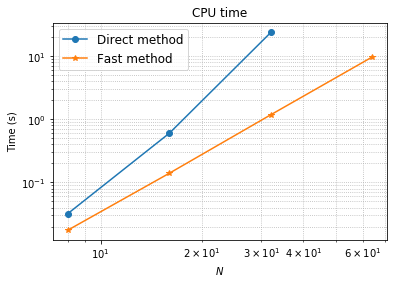

In [30]:
fig, ax = plt.subplots()
ax.loglog(N, cost_direct, 'o-', label='Direct method')
ax.loglog(N_fast, cost_fast, '*-', label='Fast method')
ax.set_xlabel('$N$')
ax.set_ylabel('Time (s)')
ax.set_title('CPU time')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')
plt.savefig('CPU time.pdf')
plt.show()

$e=0.2$, Spherical design number $= 32$

| N | Direct method | Fast method |
| ------ | ------ | ------ |
| 8 | 32.2ms | 17.6ms |
| 16 | 602ms | 140ms |
| 32 | 23.7s | 1.18s|
| 64 | -- | 9.7s |

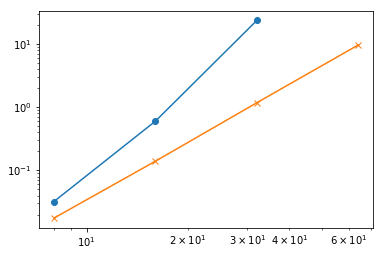

In [22]:
N = [8, 16, 32]
cost_direct = [32.2e-3, 6.02e-1, 23.7]
fig, ax = plt.subplots()
ax.loglog(N, cost_direct, 'o-', label='Computation time$')
ax.loglog(N_fast, cost_fast, 'x-', label='Computation time$')

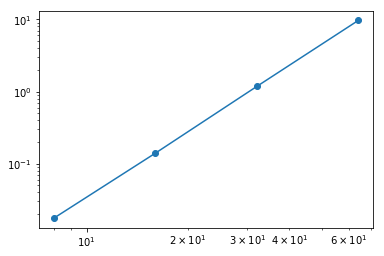

In [21]:
N_fast = [8, 16, 32, 64]
cost_fast = [17.6e-3, 1.40e-1, 1.18, 9.7]
fig, ax = plt.subplots()
ax.loglog(N_fast, cost_fast, 'o-', label='Computation time$')

In [ ]:
# 6, 223ms
np.max(np.abs(Q_direct - Q_1))

In [ ]:
# 12, 458ms
np.max(np.abs(Q_direct - Q_1))

In [ ]:
# 32, 1.22s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 48, 1.79s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 70, 2.5s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 94, 3.38s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 120, 4.43s
np.max(np.abs(Q_1 - Q_direct))

$e=0.2$, $N=32$

| Spherical Design | Error |
| ------ | ------ |
| 6 | 0.00041820767783433107 | 
| 12 | 3.1726851245650724e-05 |
| 32 | 6.5752814213618921e-07 |
| 48 | 5.6132233266191489e-07 |
| 70 | 2.6714628356683257e-07 |
| 94 | 1.0508293902503248e-07 |
| 120 | 2.8872928147741922e-08 | 

We also have $\rho_0 = 1$, $u_0 = 0$, $E = T$. Temperature $T$ safisfies:

$$
T=\left(T_0-\frac{8\varepsilon}{1-e^2}\right)\exp{\left(-\frac{1-e^2}{4}t\right)}+\frac{8\varepsilon}{1-e^2}.
$$

In [3]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [16]:
%%time

dt = 0.01
eps = 1e-6

config_3D = get_config('../src/configs/config_3D.json')
Q = FastSpectralCollison3D(config_3D)

f_hat = []

f_0 = anisotropic_f(Q.v)
E_0 = 0.5*np.sum(f_0*Q.v_norm)*Q.dv**3
f = Q.fft3(f_0).copy()

for t in range(50):
    f = RK3(f, Q.col_heat_sep, eps, dt)
    f_hat.append(f)
    
f = np.real(Q.ifft3(f))
E = 0.5*np.sum(f*Q.v_norm)*Q.dv**3

CPU times: user 23min 23s, sys: 2min 15s, total: 25min 39s
Wall time: 10min 46s


In [25]:
f[:, 10, 10]

array([ 6.67237267e-14,  6.71997803e-14,  6.77479214e-14,  6.85256368e-14,
        6.93765076e-14,  7.04335472e-14,  7.15530009e-14,  7.28438509e-14,
        7.41781719e-14,  7.56442494e-14,  7.71435171e-14,  7.87452298e-14,
        8.03908552e-14,  8.21478650e-14,  8.39823943e-14,  8.59473175e-14,
        8.80207135e-14,  9.02122665e-14,  9.24935046e-14,  9.48210436e-14,
        9.71649898e-14,  9.94494923e-14,  1.01669758e-13,  1.03722695e-13,
        1.05660063e-13,  1.07407575e-13,  1.08806473e-13,  1.09316317e-13,
        1.09194486e-13,  1.09441459e-13,  1.10023023e-13,  1.08021197e-13,
        1.03376470e-13,  9.98873972e-14,  1.00299825e-13,  9.94342473e-14,
        9.29681297e-14,  8.41743439e-14,  6.83319191e-14,  2.34843261e-14,
       -6.67298196e-14, -1.80394521e-13, -1.76559102e-13, -3.10625464e-14,
        6.79214238e-14,  8.62086499e-14,  8.39959679e-14,  8.21237344e-14,
        8.02160788e-14,  7.86237081e-14,  7.68111253e-14,  7.53172241e-14,
        7.36930189e-14,  

In [21]:
T(0.5, 0.2, eps, E_0*3/2) - E*3/2

0.14641142263066298

In [44]:
%%time
T_vhs = []
for t in range(300):
    f = np.real(Q.ifft3(f_hat[t]))
    T_vhs.append(0.5*np.sum(f*v_norm)*dv**3*2/3)

CPU times: user 273 ms, sys: 31.1 ms, total: 304 ms
Wall time: 126 ms


In [60]:
%%time
T_vhs_02 = []
for t in range(300):
    f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_02.append(0.5*np.sum(f*v_norm)*dv**3*2/3)

CPU times: user 266 ms, sys: 28.8 ms, total: 294 ms
Wall time: 117 ms


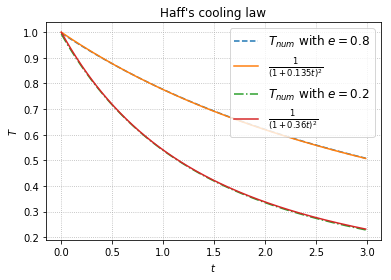

In [74]:
t = (np.arange(300)/100)

fig, ax = plt.subplots()
ax.plot(t, np.asarray(T_vhs), '--', label=r'$T_{num}$ with $e=0.8$')
ax.plot(t, 1/(1+0.135*t)**2, label=r'$\frac{1}{(1+0.135t)^2}$')
ax.plot(t, np.asarray(T_vhs_02), '-.', label=r'$T_{num}$ with $e=0.2$')
ax.plot(t, 1/(1+0.36*t)**2, label=r'$\frac{1}{(1+0.36t)^2}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$T$')
ax.set_title('Haff\'s cooling law')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')
plt.savefig('Haff\'s_cooling.pdf')
plt.show()

# plt.plot(t, np.asarray(T_vhs), '--', t, 2.25/(1+0.36*t)**2)

In [31]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [8]:
# e=0.2, 003
T(1, 0.2, eps, E_0*3/2) - E*3/2

9.747771828028107e-05

In [37]:
# e=0.2, 005
T(1, 0.2, eps, E_0*3/2) - E*3/2

0.13618309212330915

In [22]:
# e=0.2, 007
T(1, 0.2, eps, E_0*3/2) - E*3/2

-0.0016195770090696726

In [ ]:
# e=0.2, 009
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 011
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 013
T(1, e, eps, E_0*3/2) - E*3/2

In [34]:
# e=0.2, 015
T(1, 0.2, eps, E_0*3/2) - E*3/2

-0.014033867431703984

$T = 1$, $\Delta t = 0.01$

| Spherical Design | 0.2 |
| ------ | ------ |
| 6 | 0.0013957739849754791 | 
| 12 | 9.9706271716293315e-05 |
| 32 | 2.2499901350947482e-06 |
| 48 | 2.4272557155313734e-06 |
| 70 | 2.4703481364962698e-06 |
| 94 | 2.4703481364962698e-06 |
| 120 | 2.453380453903975e-06 | 